<a href="https://colab.research.google.com/github/lichouinard/aidi1002_project/blob/main/intentRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction:

For intent recognition in NLP, we can use machine learning models to classify user inputs into predefined intents. Here we will use a neural network model to build and train a simple intent recognition model using TensorFlow and Keras.

### Import all the necessary libraries and functions:

In [1]:
import json
import numpy as np
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, GRU, LSTM
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
from transformers import BertConfig, AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt

2.17.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Prepare the Dataset
This model uses intent classification dataset from Kaggle:
https://www.kaggle.com/datasets/stefanlarson/outofscope-intent-classification-dataset/data

Content

  is_train.json,is_val.json, is_test.json: these files house the train/val/test sets for the in-scope data. There are 150 in-scope "intents" (aka classes), which include samples such as "what is my balance" (which belongs to the balance class).

  oos_test.json:test sets for the out-of-scope data. There is one out-of-scope intent: oos

In [2]:
import io
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving is_test.json to is_test.json
Saving is_train.json to is_train.json
Saving is_val.json to is_val.json
Saving oos_test.json to oos_test.json


In [3]:
PATH_TO_TRAIN_DS = "/content/is_train.json"
PATH_TO_VALID_DS = "/content/is_val.json"
PATH_TO_TEST_DS = "/content/is_test.json"
PATH_TO_OOS_DATA = "/content/oos_test.json"

tf.random.set_seed(42)

In [4]:
train = np.array(json.load(open(PATH_TO_TRAIN_DS, 'r')))
val = np.array(json.load(open(PATH_TO_VALID_DS, 'r')))
test = np.array(json.load(open(PATH_TO_TEST_DS, 'r')))
oos = np.array(json.load(open(PATH_TO_OOS_DATA, 'r')))

In [ ]:
train[:,1]

array(['translate', 'translate', 'translate', ..., 'card_declined',
       'card_declined', 'card_declined'], dtype='<U136')

In [5]:
data_train = pd.DataFrame({
    'text' : train[:,0],
    'label': train[:,1]
})
data_val = pd.DataFrame({
    'text' : val[:,0],
    'label': val[:,1]
})
data_test = pd.DataFrame({
    'text' : test[:,0],
    'label': test[:,1]
})
data_oos = pd.DataFrame({
    'text' : oos[:,0],
    'label': oos[:,1]
})

In [ ]:
data_val["text"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3000 entries, 0 to 2999
Series name: text
Non-Null Count  Dtype 
--------------  ----- 
3000 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


In [ ]:
labels = np.sort(np.unique(train[:,1]))
label_to_id = {label:i for i,label in enumerate(labels)}
id_to_label = {i:label for i,label in enumerate(labels)}
num_classes = len(labels)
print(f"Number of classes: {num_classes}")

Number of classes: 150


In [ ]:
id_to_label[np.random.randint(150)]

'direct_deposit'

Tokenize the text patterns and pad the sequences to ensure uniform input shape.

Encode the intent labels and convert them to categorical one-hot encoding.

In [ ]:
# text processing
from keras.utils import to_categorical
tokenizer = Tokenizer(num_words=100, oov_token="<OOV>")
tokenizer.fit_on_texts(data_train['text'])
sequences = tokenizer.texts_to_sequences(data_train['text'])
max_length = 128
train_sequences = pad_sequences(sequences, padding='post', maxlen=max_length)


# Encode labels into integer numeric values
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(data_train['label'])

# Convert encoded labels to one-hot encoding
train_labels = to_categorical(train_labels_encoded, num_classes)

In [ ]:
data_oos.head()

,text,label
0,how much has the dow changed today,oos
1,how many prime numbers are there between 0 and...,oos
2,can you tell me how to solve simple algebraic ...,oos
3,can you dim the brightness of my screen,oos
4,what is the account number to the internet ser...,oos


In [ ]:
sequences_val = tokenizer.texts_to_sequences(data_val['text'])
val_sequences = pad_sequences(sequences_val, padding='post', maxlen=max_length)

val_labels_encoded = label_encoder.transform(data_val['label'])
val_labels = to_categorical(val_labels_encoded, num_classes)

sequences_test = tokenizer.texts_to_sequences(data_test['text'])
test_sequences = pad_sequences(sequences_test, padding='post',maxlen=max_length)

test_labels_encoded = label_encoder.transform(data_test['label'])
test_labels = to_categorical(test_labels_encoded, num_classes)

sequences_oos = tokenizer.texts_to_sequences(data_oos['text'])
oos_sequences = pad_sequences(sequences_oos, padding='post', maxlen=max_length)

In [ ]:
len(sequences_val)

In [ ]:
len(train_labels), train_labels.shape

(15000, (15000, 150))

In [ ]:
#Adjust the shape of training and validation labels
train_labels = np.reshape(train_labels, (len(train_labels), 150))
val_labels = np.reshape(val_labels, (len(val_labels), 150))
test_labels = np.reshape(test_labels, (len(test_labels), 150))

In [ ]:
val_sequences.shape, val_labels.shape,test_sequences.shape, test_labels.shape,

((3000, 28), (3000, 150), (4500, 28), (4500, 150))

In [ ]:
word_index = tokenizer.word_index
vocab_size = len(word_index) +1
max_sequence_length = max(len(sequence) for sequence in train_sequences)
embedding_dim = min(100, vocab_size // 2)

In [ ]:
max(len(sequence) for sequence in val_sequences)

28

In [ ]:
val_sequences.shape, val_labels.shape,

((3000, 28), (3000, 150))

# Evaluation Metrics

In [ ]:
def graph_history(history):

    # Get training and validation metrics from history
    training_loss = history.history['loss']
    validation_loss =history.history['val_loss']
    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    # Create a Pandas DataFrame with training and validation metrics
    history_df = pd.DataFrame({
        'Training Loss': training_loss,
        'Validation Loss': validation_loss,
        'Training Accuracy': training_accuracy,
        'Validation Accuracy': validation_accuracy
    })

    # Plot loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['Training Loss'], label='Training Loss')
    plt.plot(history_df['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot precision curves (accuracy)
    plt.figure(figsize=(10, 6))
    plt.plot(history_df['Training Accuracy'], label='Training Accuracy')
    plt.plot(history_df['Validation Accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Build Deep Learning models

**Pros:**

* Captures semantic meaning of words.
* More effective for complex and large datasets.

**Cons:**

* Requires more computational resources and data.
* More complex to implement.


##RNN

Epoch 1/15
469/469 [==============================] - 13s 23ms/step - loss: 4.4176 - accuracy: 0.0621 - val_loss: 3.9155 - val_accuracy: 0.1243
Epoch 2/15
469/469 [==============================] - 11s 24ms/step - loss: 3.6277 - accuracy: 0.1641 - val_loss: 3.5835 - val_accuracy: 0.1547
Epoch 3/15
469/469 [==============================] - 15s 32ms/step - loss: 3.2900 - accuracy: 0.2194 - val_loss: 3.3588 - val_accuracy: 0.2153
Epoch 4/15
469/469 [==============================] - 21s 44ms/step - loss: 3.0667 - accuracy: 0.2608 - val_loss: 3.2279 - val_accuracy: 0.2460
Epoch 5/15
469/469 [==============================] - 18s 39ms/step - loss: 2.9367 - accuracy: 0.2867 - val_loss: 3.3124 - val_accuracy: 0.2290
Epoch 6/15
469/469 [==============================] - 18s 38ms/step - loss: 2.7938 - accuracy: 0.3140 - val_loss: 3.0544 - val_accuracy: 0.2633
Epoch 7/15
469/469 [==============================] - 9s 20ms/step - loss: 2.6800 - accuracy: 0.3378 - val_loss: 2.9553 - val_accuracy: 

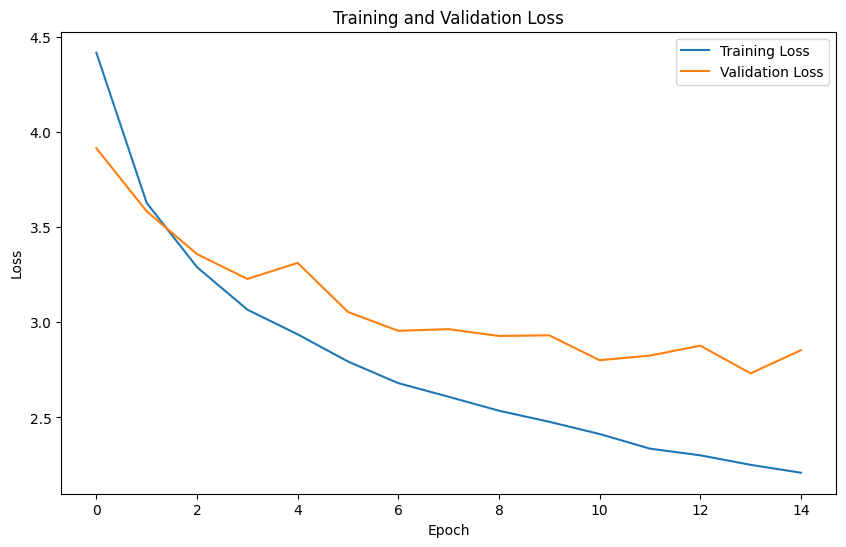

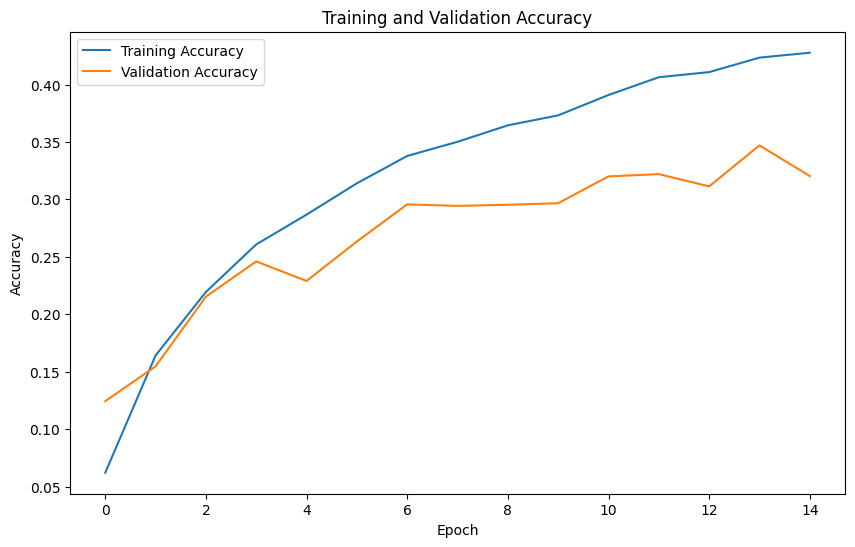

32/32 [==============================] - 0s 5ms/step
RNN Prediction: [[4.0964896e-06 3.2656841e-04 3.3892659e-06 ... 8.4160793e-06
  5.3163971e-05 1.4129365e-05]
 [2.8663391e-04 4.5715595e-04 2.1919559e-04 ... 3.3074430e-05
  7.4045347e-06 2.4421908e-05]
 [2.8225472e-02 7.3102776e-05 3.4223378e-04 ... 1.6913767e-04
  3.7662682e-04 1.2778673e-06]
 ...
 [3.7664379e-06 5.1883519e-02 1.2458874e-03 ... 1.5418424e-04
  5.0254556e-04 5.0301356e-03]
 [9.4175752e-04 1.8895780e-05 4.2689135e-03 ... 1.9803410e-04
  7.3907687e-04 3.5127567e-04]
 [1.9725726e-03 2.3981002e-05 4.1744708e-05 ... 4.5302674e-02
  1.7952362e-01 1.5858767e-04]]


In [ ]:
# Define the recurrent neural network model
model_RNN = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    SimpleRNN(128, input_shape=(train_sequences.shape[1], 1)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_RNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_RNN = model_RNN.fit(train_sequences, train_labels, epochs=15, validation_data=(val_sequences, val_labels))

# Evaluate model performance on the test set
loss, accuracy = model_RNN.evaluate(test_sequences, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')
graph_history(history_RNN)

# Predict with RNN model
rnn_prediction = model_RNN.predict(oos_sequences)
for i in range(10):
  print(oos[i,0], ":", id_to_label[np.argmax(rnn_prediction[i])])

##GRU

Epoch 1/15
469/469 [==============================] - 27s 52ms/step - loss: 5.0134 - accuracy: 0.0059 - val_loss: 5.0114 - val_accuracy: 0.0067
Epoch 2/15
469/469 [==============================] - 27s 59ms/step - loss: 4.8074 - accuracy: 0.0155 - val_loss: 4.5162 - val_accuracy: 0.0330
Epoch 3/15
469/469 [==============================] - 21s 45ms/step - loss: 3.8693 - accuracy: 0.0839 - val_loss: 3.5876 - val_accuracy: 0.1243
Epoch 4/15
469/469 [==============================] - 20s 43ms/step - loss: 3.0744 - accuracy: 0.2202 - val_loss: 2.9527 - val_accuracy: 0.2613
Epoch 5/15
469/469 [==============================] - 38s 82ms/step - loss: 2.5451 - accuracy: 0.3441 - val_loss: 2.6191 - val_accuracy: 0.3407
Epoch 6/15
469/469 [==============================] - 35s 75ms/step - loss: 2.1988 - accuracy: 0.4305 - val_loss: 2.4025 - val_accuracy: 0.4077
Epoch 7/15
469/469 [==============================] - 20s 44ms/step - loss: 1.9576 - accuracy: 0.4927 - val_loss: 2.2725 - val_accuracy:

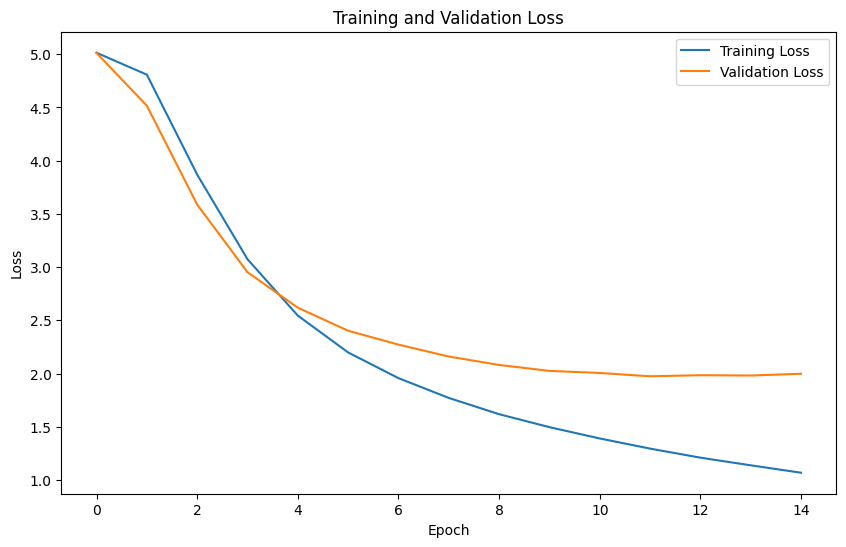

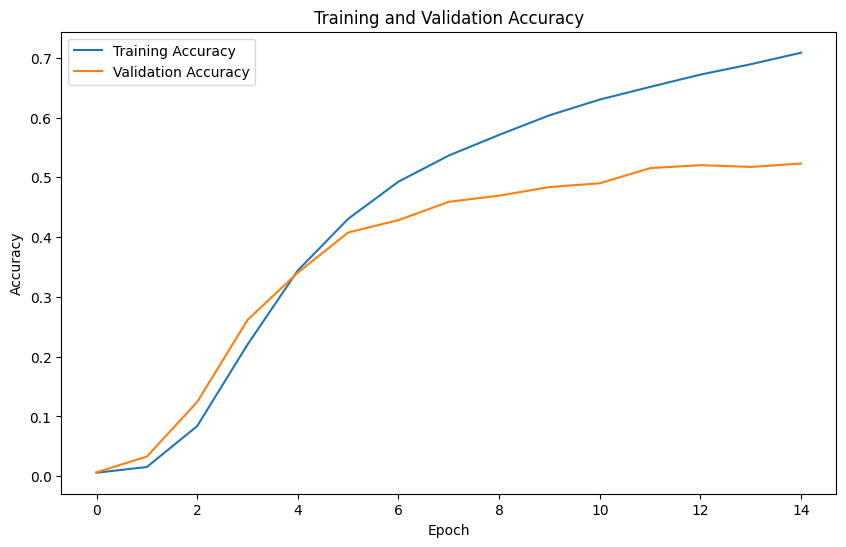

32/32 [==============================] - 2s 19ms/step
GRU Prediction: [[4.1106770e-05 2.7510381e-04 5.6988974e-05 ... 5.7735022e-05
  1.9391131e-03 5.8570632e-04]
 [6.7249546e-04 9.5667374e-06 9.0633675e-06 ... 1.6489918e-06
  7.4074710e-06 2.7057780e-05]
 [2.0640022e-04 7.2083880e-05 3.4861241e-05 ... 5.8520254e-06
  1.5021486e-05 1.2245877e-05]
 ...
 [7.3097550e-07 5.2762136e-04 8.5471565e-04 ... 8.4086441e-06
  5.2049611e-04 9.0361579e-04]
 [1.7236151e-02 4.9654340e-05 6.5927334e-02 ... 9.6214365e-04
  1.7135151e-04 6.9920946e-04]
 [6.1067141e-05 6.0716879e-06 9.6338760e-04 ... 1.2083328e-06
  1.2222581e-04 3.2841414e-03]]


In [ ]:
# Define the recurrent neural network model
model_GRU = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    GRU(128, input_shape=(train_sequences.shape[1], 1)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_GRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_GRU = model_GRU.fit(train_sequences, train_labels, epochs=15, validation_data=(val_sequences, val_labels))

#Evaluate model performance on the test set
loss, accuracy = model_GRU.evaluate(test_sequences, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')
graph_history(history_GRU)

# Predict with GRU model
gru_prediction = model_GRU.predict(oos_sequences)
print("GRU Prediction:", gru_prediction)


##LSTM

In [ ]:
# Define the recurrent neural network model
model_LSTM = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    LSTM(128, input_shape=(train_sequences.shape[1], 1)),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model_LSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model
history_LSTM = model_LSTM.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels))

# Evaluate model performance on the test set
loss, accuracy = model_LSTM.evaluate(test_sequences, test_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')
graph_history(history_LSTM)

# Predict with LSTM model
lstm_prediction = model_LSTM.predict(oos_sequences)
print("LSTM Prediction:", lstm_prediction)

In [ ]:
for i in range(10):
  print("text                      : rnn           : gru        : lstm")
  print(oos[i,0], ":", id_to_label[np.argmax(rnn_prediction[i])], ":", id_to_label[np.argmax(gru_prediction[i])], ":", id_to_label[np.argmax(lstm_prediction[i])])

text                      : rnn           : gru        : lstm
how much has the dow changed today : taxes : pto_used : interest_rate
text                      : rnn           : gru        : lstm
how many prime numbers are there between 0 and 100 : exchange_rate : exchange_rate : calories
text                      : rnn           : gru        : lstm
can you tell me how to solve simple algebraic equations with one variable : exchange_rate : order_checks : nutrition_info
text                      : rnn           : gru        : lstm
can you dim the brightness of my screen : current_location : order_status : order_status
text                      : rnn           : gru        : lstm
what is the account number to the internet service i have : routing : calendar : routing
text                      : rnn           : gru        : lstm
can you see a hdmi cord : roll_dice : roll_dice : roll_dice
text                      : rnn           : gru        : lstm
what veggies can i pair with mushrooms : d

## Analyze parameters impacts

1. **Vocabulary Size (num_words in Tokenizer):**

 * **Impact**: This parameter determines the maximum number of unique words the model will consider, based on word frequency in the training data.
    - **Larger Vocabulary**: Captures more nuanced language and potentially improves accuracy, but may introduce noise and increase computational complexity.
    - **Smaller Vocabulary**: Reduces complexity and might be faster to train, but risks missing important words and potentially lowering accuracy.

2. **Out-of-Vocabulary Token (oov_token in Tokenizer):**
 * **Impact**: Handles words not present in the training vocabulary, crucial for real-world applications where users might use unexpected terms.
    - **Proper Handling:** Ensures the model doesn't break when encountering new words and can still provide a reasonable prediction.
    - **Lack of Handling**: Can lead to errors or inaccurate predictions when encountering unseen words.
3.** Sequence Length (maxlen in pad_sequences):**

 * **Impact**: Determines the length to which all input sequences are padded or truncated.
    - **Longer Sequences**: Capture more context, potentially improving accuracy, but increase computational cost.
    - **Shorter Sequences**: Reduce complexity and training time, but might lose important contextual information.
4. **RNN Model Parameters:**

 * **Embedding Layer:**
    - **input_dim**: Vocabulary size, impacting the embedding layer's input dimension.
    - **output_dim**: Dimensionality of word embeddings, affecting the richness of word representations.
    - **input_length**: Length of input sequences, influencing the shape of input tensors.
 * **RNN Layers (SimpleRNN, GRU, LSTM):**

    - **units:** Number of hidden units in the RNN layer, impacting the model's capacity to learn complex patterns.
 * **Dense Layer:**

    - **units:** Number of output units, should match the number of intent classes.
    - **activation:** Typically 'softmax' for multi-class classification, converting model outputs to probabilities for each class.
 * **Optimizer:**

    - **Choice of Optimizer:** Affects how the model learns from data (e.g., 'adam' is commonly used).
      * **Adam (Adaptive Moment Estimation)**
        - **Pros:** Adaptive learning rates, momentum, efficient, less parameter tuning.
        - **Cons:** May not be optimal for all types of problems; tuning learning rate might still be necessary in some cases.
      * **RMSProp (Root Mean Square Propagation)**
        - **Pros:** Works well for RNNs, particularly on problems with lots of noisy data.
        - **Cons:** Requires tuning of the learning rate.
    - **Learning Rate:** Influences the step size during training, impacting convergence speed and potential overfitting.
 * **Key Considerations:**

    - **Trade-offs:** Adjusting these parameters involves trade-offs between accuracy, complexity, and computational cost.
    - **Experimentation:** Finding the optimal parameter values often requires experimentation and validation on your specific dataset.

## **SimpleRNN vs GRU vs LSTM**

1. **SimpleRNN**
* **Architecture**:
 * The basic form of an RNN.
 * Each unit has a hidden state that is updated at each time step.
 * Uses the hidden state from the previous time step to influence the current state.
* **Pros**:
 * Simpler and computationally less expensive compared to GRU and LSTM.
 * Easier to implement and understand.
 * Suitable for problems with short-term dependencies.
* **Cons**:
 * Struggles with learning long-term dependencies due to the vanishing gradient problem.
 * Limited memory capacity.
2. **GRU (Gated Recurrent Unit)**
* **Architecture**:
 * Introduced to address the limitations of SimpleRNN.
Combines the hidden state and cell state into a single state.
 * Uses gating mechanisms (reset gate and update gate) to control the flow of information.
* **Pros**:
 * Addresses the vanishing gradient problem better than SimpleRNN.
 * More efficient than LSTM due to fewer parameters.
 * Often performs well on a variety of tasks.
* **Cons**:
 * More complex and computationally expensive than SimpleRNN.
 * Slightly less expressive than LSTM due to fewer gates.
3. **LSTM (Long Short-Term Memory)**
* **Architecture:**
 * Designed to address both the vanishing and exploding gradient problems.
 * Maintains a separate cell state in addition to the hidden state.
 * Uses three gates: input gate, forget gate, and output gate to regulate information flow.
* **Pros:**
 * Excellent at learning long-term dependencies.
 * More expressive and powerful due to its gating mechanisms.
 * Widely used and proven effective in many sequential tasks like text generation, machine translation, etc.
* **Cons:**
 * More complex and computationally expensive due to a larger number of parameters.
 * Slower to train compared to SimpleRNN and GRU.

#TF-IDF + Machine Learning Classifiers
**Characteristics:**

* Uses Term Frequency-Inverse Document Frequency (TF-IDF) to convert text into vector representation.
* Applies traditional machine learning classifiers on these vectors.

**Pros:**

* Considers the importance of words.
* Works well for various NLP tasks.

**Cons:**

* Ignores word order and context.
* Requires feature engineering.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

In [ ]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(data_train['text'])
y_train = data_train['label']

In [ ]:
classifier = SVC()
classifier.fit(X_train, y_train)

SVC()

In [ ]:
X_train.shape

(15000, 5026)

In [ ]:
X_val = vectorizer.transform(data_val['text'])
X_test = vectorizer.transform(data_test['text'])
y_val = data_val['label']
y_test = data_test['label']

In [ ]:
X_val.shape, X_test.shape

((3000, 5026), (4500, 5026))

In [ ]:
y_val_pred = classifier.predict(X_val)
y_test_pred = classifier.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
accuracy_val = accuracy_score(y_val, y_val_pred)
print("Accuracy val :", accuracy_val)
accuracy_test = accuracy_score(y_test, y_test_pred)
print("Accuracy test :", accuracy_test)
print(classification_report(y_test, y_test_pred))

Accuracy val : 0.9036666666666666
Accuracy test : 0.9082222222222223
                           precision    recall  f1-score   support

      accept_reservations       0.96      0.87      0.91        30
          account_blocked       0.97      0.93      0.95        30
                    alarm       0.97      0.97      0.97        30
       application_status       0.97      1.00      0.98        30
                      apr       0.97      1.00      0.98        30
            are_you_a_bot       0.97      1.00      0.98        30
                  balance       1.00      0.93      0.97        30
             bill_balance       0.93      0.93      0.93        30
                 bill_due       0.93      0.83      0.88        30
              book_flight       0.94      0.97      0.95        30
               book_hotel       0.97      1.00      0.98        30
               calculator       0.62      0.93      0.75        30
                 calendar       0.87      0.67      0.75   

In [ ]:
X_oos = vectorizer.transform(oos[:,0])
y_oos_pred = classifier.predict(X_oos)

In [ ]:
for i in range(10):
  print(oos[i,0], ":", y_oos_pred[i])

how much has the dow changed today : income
how many prime numbers are there between 0 and 100 : measurement_conversion
can you tell me how to solve simple algebraic equations with one variable : greeting
can you dim the brightness of my screen : smart_home
what is the account number to the internet service i have : account_blocked
can you see a hdmi cord : goodbye
what veggies can i pair with mushrooms : what_can_i_ask_you
can you put the car in fuel efficient mode : gas_type
at what age can someone get a card : how_old_are_you
please find today's most read stories from the new york times todayi : calculator


# Use pretrained intent classification model from hugging face for oos data

In [6]:
import os
from huggingface_hub import hf_hub_download

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

model_name = 'qanastek/XLMRoberta-Alexa-Intents-Classification'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/398 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.00k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [14]:
for i in range(10):
  res = classifier(data_oos['text'][i])
  print(data_oos['text'][i], res)

how much has the dow changed today [{'label': 'qa_stock', 'score': 0.9999207258224487}]
how many prime numbers are there between 0 and 100 [{'label': 'qa_factoid', 'score': 0.9592407941818237}]
can you tell me how to solve simple algebraic equations with one variable [{'label': 'general_quirky', 'score': 0.9968662858009338}]
can you dim the brightness of my screen [{'label': 'iot_hue_lightdim', 'score': 0.9972670078277588}]
what is the account number to the internet service i have [{'label': 'email_querycontact', 'score': 0.8826463222503662}]
can you see a hdmi cord [{'label': 'general_quirky', 'score': 0.9010863900184631}]
what veggies can i pair with mushrooms [{'label': 'cooking_recipe', 'score': 0.9999054670333862}]
can you put the car in fuel efficient mode [{'label': 'transport_traffic', 'score': 0.22128772735595703}]
at what age can someone get a card [{'label': 'general_quirky', 'score': 0.999889612197876}]
please find today's most read stories from the new york times todayi [{

# Models results comparison
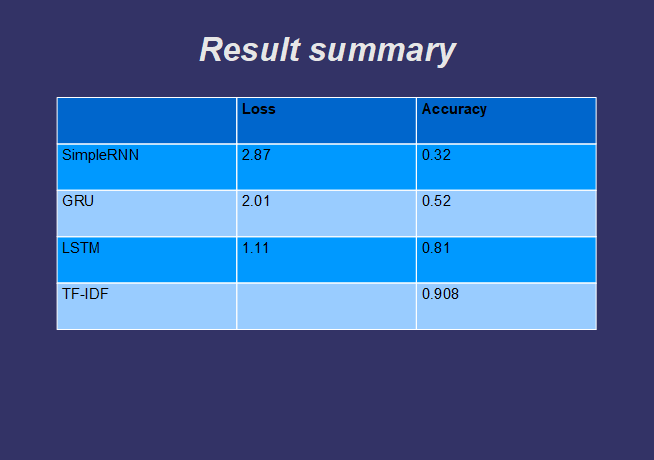

#Out of scope data comparision
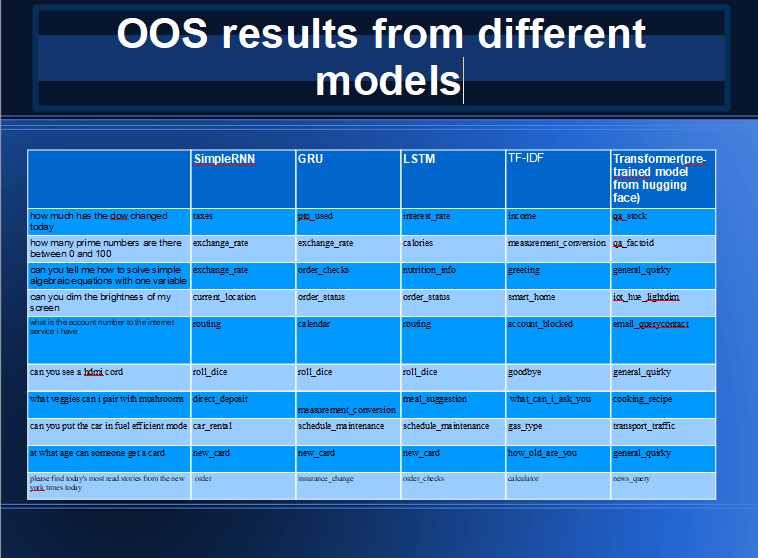

# **Conclusion** ##

Here is the summary for picking models for intent recognition in NLP:

1. **Understand the problem and requirements**

*  **Data Characteristics:** Type and size of your text data, number of intents, and language complexity.
*   **Performance Metrics:** Key metrics such as accuracy, F1 score, latency, and resource constraints.

2. **Data Preparation**
* **Text Cleaning:** Remove noise, handle misspellings, and normalize text.
* **Tokenization:** Split text into meaningful units (words, subwords).
* **Handling Stop Words:** Remove or keep based on the specific use case.
* **Encoding:** Convert text to numerical representations (word embeddings, one-hot encoding).

3. **Model Selection for NLP**
*
When choosing models specifically for NLP tasks like intent recognition, the landscape of models and techniques is vast and continuously evolving. Here’s a focused summary for picking models for intent recognition in NLP:

1. Understand the Problem and Requirements
Data Characteristics: Look at the type and size of your text data, number of intents, and language complexity.
Performance Metrics: Define key metrics such as accuracy, F1 score, latency, and resource constraints.
2. Data Preparation
Text Cleaning: Remove noise, handle misspellings, and normalize text.
Tokenization: Split text into meaningful units (words, subwords).
Handling Stop Words: Remove or keep based on the specific use case.
Encoding: Convert text to numerical representations (word embeddings, one-hot encoding).
3. Model Selection for NLP
* **Traditional Machine Learning Models:** such as TF-IDF or SVM
* **Deep Learning Models** : such as RNN, LSTM, GRU
* **Pre-trained Language Models**: such as BERT or GPT

4. **Model Training and Fine-Tuning**
* **Training:** Train models on your specific dataset. For traditional models, this involves feature extraction (TF-IDF, word embeddings). For deep learning, this means using raw or tokenized text.
* **Fine-Tuning:** tuning parameters for your model. For pre-trained models, fine-tune on your dataset to adapt the model to the specific task and domain.
5. ** Model Evaluation**
* **Metrics:** Evaluate using metrics like accuracy, precision, recall, and F1 score.
* **OOV handling**: use out of scope data to evaluate OOV handling

Each type of model has its advantages and trade-offs, so the best choice depends on the specific NLP task, dataset characteristics, and resource constraints. Fine-tuning pre-trained models is often the best approach for achieving high performance in intent recognition tasks.